In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from tqdm.notebook import tqdm

In [2]:
np.random.seed(0)
torch.manual_seed(0)

In [3]:
mean = np.array([0.485 , 0.456 , 0.406])
std= np.array([0.229 , 0.224 , 0.225])

In [4]:
image_transforms = {
    "train": transforms.Compose([
        #transforms.RandomHorizontalFlip(),
        #transforms.RandomResizedCrop(1024),
        #transforms.RandomRotation(20),
        transforms.Resize((512, 512)),
        transforms.ToTensor(),
        #transforms.Normalize(mean,std)
    ]),
    "test": transforms.Compose([
        transforms.Resize((512, 512)),
        #transforms.RandomResizedCrop(1024),
        transforms.ToTensor(),
        transforms.Normalize(mean,std)])
}

In [5]:
data_dir = 'data'
image_dataset_train = datasets.ImageFolder(root = data_dir ,
                                      transform = image_transforms["train"]
                                     )
image_dataset_test = datasets.ImageFolder(root = data_dir ,
                                            transform = image_transforms["test"]
                                           )

class_names = image_dataset_train.classes
print(class_names)
print(class_names[27])

['Brother', 'mom', 'أمام', 'اب', 'اتمني لك حياة سعيدة', 'اخ', 'اخبارك', 'اسمك', 'اشرب', 'السلام عليكم', 'ايه', 'بنت', 'بيت', 'حب الخير', 'حسبي الله ونعم الوكيل', 'داخل', 'دكتور', 'زواج', 'سرير', 'صديق', 'عمرك', 'كام', 'كرسي', 'مرتبه', 'مركز', 'مريض', 'مسجد', 'مسن', 'مصر', 'معزه', 'ناس', 'هلال', 'هنا', 'هناك', 'ولد', 'يسار', 'يمين', 'ينادي']
مسن


In [19]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# print(image_dataset_train)


In [7]:
dataset_size = len(image_dataset_train)
dataset_indices = list(range(dataset_size))

In [8]:
np.random.shuffle(dataset_indices)

In [9]:
val_split_index = int(np.floor(0.2 * dataset_size))

In [10]:
train_idx, val_idx = dataset_indices[val_split_index:], dataset_indices[:val_split_index]

In [11]:
train_sampler = SubsetRandomSampler(train_idx)
val_sampler = SubsetRandomSampler(val_idx)

In [12]:
train_loader = DataLoader(dataset=image_dataset_train, shuffle=False, batch_size=4, sampler=train_sampler)
val_loader = DataLoader(dataset=image_dataset_train, shuffle=False, batch_size=1, sampler=val_sampler)
test_loader = DataLoader(dataset=image_dataset_test, shuffle=False, batch_size=1)

اتمني لك حياة سعيدة


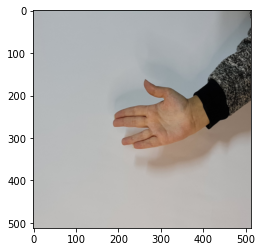

In [13]:
idx = 500

img = image_dataset_train[idx][0].permute(1,2,0).numpy()
#img = img*std  + mean
label = image_dataset_train[idx][1]

plt.imshow(img)
print(class_names[label])

In [14]:
m = models.resnet50(pretrained=True)
num_ftrs = m.fc.in_features
m.fc = nn.Linear(num_ftrs, 38)
m.to("cuda")
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(m.parameters(), lr=0.008)

In [15]:
def multi_acc(y_pred, y_test):
    y_pred_softmax = torch.log_softmax(y_pred, dim = 1)
    _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)    
    
    correct_pred = (y_pred_tags == y_test).float()
    acc = correct_pred.sum() / len(correct_pred)
    
    acc = torch.round(acc * 100)
    
    return acc

In [16]:
accuracy_stats = {
    'train': [],
    "val": []
}
loss_stats = {
    'train': [],
    "val": []
}

In [17]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [18]:
m.train()
for e in tqdm(range(1)):
#for epoch in range(10):
    # TRAINING
    train_epoch_loss = 0
    train_epoch_acc = 0
    train_epoch_acc_best = 80.0
    for i , (X_train_batch, y_train_batch) in enumerate (train_loader):
        X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
        #y_train = F.one_hot(y_train_batch, num_classes=12)
        #y_train = y_train.type(torch.cuda.FloatTensor)
        #print(y_train)
        optimizer.zero_grad()
        #y_train_pred = m(X_train_batch).squeeze()
        
        y_train_pred = m(X_train_batch)
        #_,prediction = torch.max(y_train_pred, dim=1)
        #pred = prediction.type(torch.cuda.FloatTensor)
        #print(type(pred))
        #print(f' label {y_train_batch} | prediction {pred}')
        train_loss = criterion(y_train_pred, y_train_batch)
        #train_acc = binary_acc(y_train_pred, y_train_batch)
        
        train_acc = multi_acc(y_train_pred, y_train_batch)
        train_loss.backward()
        optimizer.step()
        
        train_epoch_loss += train_loss.item()
        train_epoch_acc += train_acc.item()
        
        
        if (i %50 == 0):
            if (i == 0 ):
                continue
            else:
                '''
                with torch.no_grad():
                    m.eval()
                    val_epoch_loss = 0
                    val_epoch_acc = 0
                    for X_val_batch, y_val_batch in val_loader:
                        X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)

                        y_val = F.one_hot(y_val_batch, num_classes=12)
                        y_val = y_train.type(torch.cuda.FloatTensor)

                        y_val_pred = m(X_val_batch)
                        #y_val_pred = torch.unsqueeze(y_val_pred, 0)
                        val_loss = criterion(y_val_pred, y_val)
                        val_acc = multi_acc(y_val_pred, y_val_batch)
                        val_epoch_loss += val_loss.item()
                        val_epoch_acc += val_acc.item()
                '''
                #print(f'Epoch {e+0:02}: | Train Loss: {train_epoch_loss/i:.5f} | Val Loss: {val_epoch_loss/len(val_loader):.5f} | Train Acc: {train_epoch_acc/i:.3f}| Val Acc: {val_epoch_acc/len(val_loader):.3f}')
                #print(f'Epoch {e+0:02}: | Train Loss: {train_epoch_loss/len(train_loader):.5f} | Train Acc: {train_epoch_acc/len(train_loader):.3f}')
                print(f'Epoch {e+0:02}: | Train Loss: {train_epoch_loss/i:.5f} | Train Acc: {train_epoch_acc/i:.3f}')
    print(f' Accuracy of Epoch {e+0:02} : {train_epoch_acc/len(train_loader):.3f}')
    if (train_epoch_acc/len(train_loader))> train_epoch_acc_best:
        train_epoch_acc_best = train_epoch_acc/len(train_loader)
        torch.save(m,'check_transfer_512_resnet50_38.pth')
        print("Model saved ..")
    #torch.save(m,'check_transfer2.pth')

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 00: | Train Loss: 0.27707 | Train Acc: 94.500
Epoch 00: | Train Loss: 0.32784 | Train Acc: 90.250
Epoch 00: | Train Loss: 0.34311 | Train Acc: 88.333
Epoch 00: | Train Loss: 0.31901 | Train Acc: 89.375
Epoch 00: | Train Loss: 0.32870 | Train Acc: 88.700
Epoch 00: | Train Loss: 0.32153 | Train Acc: 89.333
Epoch 00: | Train Loss: 0.33061 | Train Acc: 89.000
Epoch 00: | Train Loss: 0.33027 | Train Acc: 89.062
Epoch 00: | Train Loss: 0.33222 | Train Acc: 89.278
Epoch 00: | Train Loss: 0.33202 | Train Acc: 89.300
Epoch 00: | Train Loss: 0.32910 | Train Acc: 89.545
Epoch 00: | Train Loss: 0.32357 | Train Acc: 89.750
Epoch 00: | Train Loss: 0.32952 | Train Acc: 89.577
Epoch 00: | Train Loss: 0.33106 | Train Acc: 89.500
Epoch 00: | Train Loss: 0.33393 | Train Acc: 89.433
 Accuracy of Epoch 00 : 89.309
Model saved ..


In [83]:
# VALIDATION
m= torch.load('check_transfer_512_resnet50_38.pth')
#print(checkpoint)
#m.load_state_dict(torch.load('check_transfer.pth'))
#m = checkpoint['state_dict']
with torch.no_grad():
    m.eval()
    val_epoch_loss = 0
    val_epoch_acc = 0
    for X_val_batch, y_val_batch in val_loader:
        X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
        
        #y_val = F.one_hot(y_val_batch, num_classes=12)
        #y_val = y_train.type(torch.cuda.FloatTensor)
        
        y_val_pred = m(X_val_batch)
        #y_val_pred = torch.unsqueeze(y_val_pred, 0)
        val_loss = criterion(y_val_pred, y_val_batch)
        val_acc = multi_acc(y_val_pred, y_val_batch)
        val_epoch_loss += val_loss.item()
        val_epoch_acc += val_acc.item()
                
#print(f'Epoch {e+0:02}: | Train Loss: {train_epoch_loss/len(train_loader):.5f} | Val Loss: {val_epoch_loss/len(test_loader):.5f} | Train Acc: {train_epoch_acc/len(train_loader):.3f}| Val Acc: {val_epoch_acc/len(test_loader):.3f}')
print(f'Epoch {e+0:02}: | Val Loss: {val_epoch_loss/len(val_loader):.5f} | Val Acc: {val_epoch_acc/len(val_loader):.3f}')
 

Epoch 01: | Val Loss: 0.34488 | Val Acc: 89.495


In [41]:
import cv2

tensor([[ -8.6020,  -2.8377,  -4.0034,  -8.0649, -15.0134,  -1.4907, -10.2602,
         -11.6874,  -0.6435,  -3.8563,  -5.3627, -13.9091,  -9.7015,  -4.2732,
         -12.6562, -11.1504,  -8.7605,  -8.6687, -13.5833,  -2.3807, -14.0702,
          -9.3015, -16.6490, -16.7478,  -4.0455,  -7.2321, -11.0031, -10.3480,
         -12.1095, -18.2152, -11.7294, -11.4558,  -6.5411,  -5.6026,  -4.6051,
          -6.8903,  -5.6643,  -6.6345]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward0>)
tensor([8], device='cuda:0')
prediction is:  اشرب


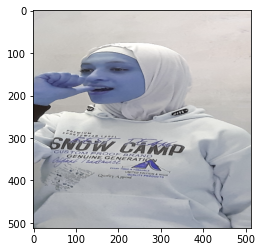

In [70]:
#test
img = cv2.imread(r"C:\Users\Ali\Sign_Language_Project\test\20211209_120335.jpg")
img = cv2.resize(img , (512,512))
plt.imshow(img)
img_ten = torch.from_numpy(img)
img_ten = img_ten.to(device)
img_ten = torch.permute(img_ten , (2,1,0))
img_ten = torch.unsqueeze(img_ten,0)
img_ten = img_ten.type(torch.cuda.FloatTensor)
pred = m(img_ten)

y_pred_softmax = torch.log_softmax(pred, dim = 1)
_, y_pred_tags = torch.max(y_pred_softmax, dim = 1) 
print(y_pred_softmax)
print(y_pred_tags)
print("prediction is: " , class_names[y_pred_tags])